Going to model the data here.

 final_simplex: (array([[1.14609260e+06, 2.06724401e-05, 9.82450961e+00],
       [1.14609260e+06, 2.06724401e-05, 9.82450961e+00],
       [1.14609260e+06, 2.06724401e-05, 9.82450961e+00],
       [1.14609260e+06, 2.06724401e-05, 9.82450961e+00]]), array([4.93104113e-10, 4.93104113e-10, 4.93104114e-10, 4.93572404e-10]))
           fun: 4.931041133487904e-10
       message: 'Optimization terminated successfully.'
          nfev: 282
           nit: 144
        status: 0
       success: True
             x: array([1.14609260e+06, 2.06724401e-05, 9.82450961e+00])


<Figure size 10000x4800 with 0 Axes>

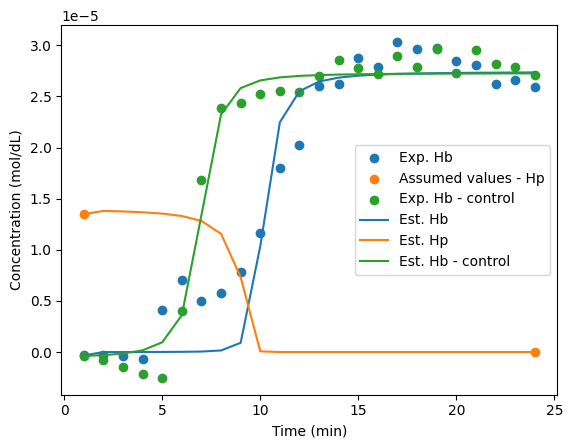

<Figure size 10000x4800 with 0 Axes>

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import Bounds
from plotdf import plotdf

data = pd.read_excel('data.xlsx')
s=1.38476998e-05
mu=7
time = np.linspace(1, 24, 24)
hbin = 2.7E-5
hpin = hbin/2
hpx = [1, 24]
hpy = [hpin, 0]
ic = ([data.loc[0, "hpadj mol/dL"], hpin, data.loc[0, "cadj mol/dL"]])
ac = (10E5, s*3, 8)

def func(x, t, kr, sB, muB):
    B, P, C = x
    dB = - kr * B * P + sB/((((t-muB)**2)+1)**(3/2))
    dP = - kr * B * P
    dC = s/((((t-mu)**2)+1)**(3/2))
    return(dB, dP, dC)

def err(params):
    kr, sB, muB = params
    ODEoutput = odeint(func, ic, time, args = (kr, sB, muB))
    errB = (ODEoutput[:,0] - data["hpadj mol/dL"])**2
    errP = (np.array(ODEoutput[0,1], ODEoutput[23, 1]) - np.array(hpy))**2
    errC = (ODEoutput[:,2] - data["cadj mol/dL"])**2
    return (np.sum(errB) + np.sum(errC) + np.sum(errP))

bounds = ([0, 10E100], [0, 10E100], [0, 10E100])
sol = minimize(err, x0 = ac, bounds = bounds, method = "Nelder-Mead")
print(sol)

fitdata = odeint(func, ic, data["time"], args=(sol.x[0], sol.x[1], sol.x[2]))
#print(fitdata)
plt.scatter(data["time"], data['hpadj mol/dL'], label = "Exp. Hb")
plt.scatter(hpx, hpy, label = "Assumed values - Hp")
plt.scatter(data["time"], data['cadj mol/dL'], label = "Exp. Hb - control")
plt.plot(data["time"], fitdata[:,0], label = "Est. Hb")
plt.plot(data["time"], fitdata[:,1], label = "Est. Hp")
plt.plot(data["time"], fitdata[:,2], label = "Est. Hb - control")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mol/dL)")
plt.legend(loc = "right")
plt.figure(figsize = (100, 48))

In [22]:
# plotdf(func, # Function giving the rhs of the diff. eq. system
#      np.array([0,200]), # [xmin,xmax]
#      np.array([0,200]),# [ymin,ymax]
#      [(0,150)], # list of initial values for trajectories (optional)
#      # Additional parameters for `f` (optional)
#      parameters={"GB":50,"kr":0.3,"GP":0.01},
#      gridsteps=20,
#      nsteps = 10000,
#      tmax=20)

# plt.xlabel("B, concentration of hemoglobin (g/dL)")
# plt.ylabel("P, concentration of haptoglobin (g/dL)")

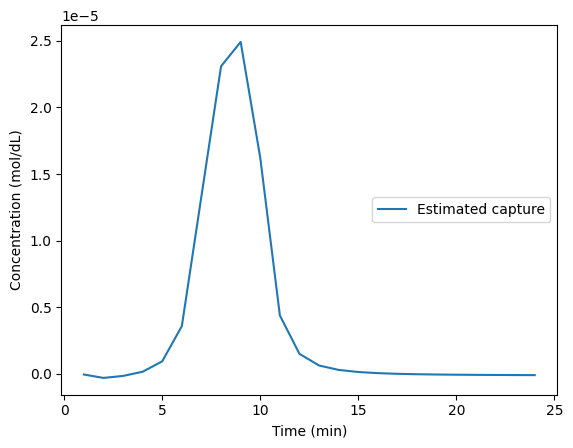

In [23]:
capdata = fitdata[:,2] - fitdata[:,0]

plt.plot(data["time"], capdata, label = "Estimated capture")
plt.xlabel("Time (min)")
plt.ylabel("Concentration (mol/dL)")
plt.legend(loc = "right")